# Extra Material: Training a MoE Model for Graph Classification

**Author:** yifei.song@loria.fr

## Section 0 - Environment Setup

In [1]:
# Check kernel
import sys
print(sys.executable)

/home/ysong/notebooks/myenv/bin/python


In [2]:
!{sys.executable} -m pip list

Package                  Version
------------------------ -----------
accelerate               1.6.0
aiohappyeyeballs         2.6.1
aiohttp                  3.11.16
aiosignal                1.3.2
asttokens                3.0.0
async-timeout            5.0.1
attrs                    25.3.0
certifi                  2025.1.31
charset-normalizer       3.4.1
click                    8.1.8
comm                     0.2.2
datasets                 3.5.0
debugpy                  1.8.14
decorator                5.2.1
dill                     0.3.8
exceptiongroup           1.2.2
executing                2.2.0
filelock                 3.18.0
frozenlist               1.5.0
fsspec                   2024.12.0
huggingface-hub          0.30.2
idna                     3.10
importlib-metadata       8.6.1
ipykernel                6.29.5
ipython                  8.18.1
jedi                     0.19.2
jinja2                   3.1.6
joblib                   1.4.2
jupyter-client           8.6.3
jupyter-core   

In [3]:
import os
import re
import torch
import random
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset
from nltk.tokenize import sent_tokenize
import nltk
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator
)

nltk.download('punkt_tab')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

/home/ysong/notebooks/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /home/ysong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Section 1 - Load WebNLG dataset

In [4]:
# Load WebNLG dataset from HuggingFace
webnlg_data = load_dataset("webnlg-challenge/web_nlg", "release_v3.0_en")

In [5]:
# Graph pre-processing functions
def from_camel(s: str) -> str:
    """
    Convert a camelCase string into a space-separated lowercase string.
    Example: birthPlace -> 'birth place'
    """
    return re.sub(r'([A-Z])', r' \1', s).lower()

def to_camel(s: str) -> str:
    """
    Convert a space-separated or snake_case string to camelCase.
    Example: city_served -> cityServed
    """
    s = re.sub(r"(_|-)+", " ", s).title().replace(" ", "")
    return s[0].lower() + s[1:]

def linearize_graph(triple_list):
    """
    Convert a list of triples into a single linearized string, e.g.:
    ['Aarhus_Airport | cityServed | "Aarhus, Denmark"']
      -> '[S] Aarhus Airport [P] cityServed [O] Aarhus, Denmark'
    """
    linearized_graph = ""
    for triple in triple_list:
        sub, pred, obj = triple[0].split(" | ")
        sub = sub.replace("_", " ").strip('"')
        pred = to_camel(from_camel(pred))
        obj = obj.replace("_", " ").strip('"')
        linearized_graph += f" [S] {sub} [P] {pred} [O] {obj}"
    return linearized_graph.strip()


In [6]:
def create_webnlg_hf_dataset(raw_split_data, tokenizer, label2id, max_length=128):
    """
    Convert raw WebNLG data into a Hugging Face Dataset suitable for Trainer.

    Args:
        raw_split_data (List[Dict]): e.g. webnlg_data["train"]
        tokenizer (PreTrainedTokenizer): e.g. BertTokenizer
        label2id (Dict[str, int]): e.g. {"Airport": 0, "Astronaut": 1, ...}
        max_length (int): Maximum sequence length for tokenization

    Returns:
        Dataset: A Hugging Face Dataset with tokenized "input_ids", "attention_mask", and "labels".
    """
    # 1) Make raw split data into list of dict
    processed = []
    for example in raw_split_data:
        triple_list = example["modified_triple_sets"]["mtriple_set"]
        category = example["category"]
        if category not in label2id:
            continue  # Skip unseen categories
        text = linearize_graph(triple_list)
        label_id = label2id[category]
        processed.append({"text": text, "label": label_id})

    # 2) Convert to HF Dataset
    ds = Dataset.from_list(processed)

    # 3) Tokenization
    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    ds = ds.map(tokenize_fn, batched=True)

    # 4) Remove "text"
    ds = ds.remove_columns(["text"])  # Only keep input_ids, attention_mask, label
    # Rename
    ds = ds.rename_column("label", "labels")

    return ds

In [13]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

# Add Special Tokens
special_tokens_dict = {"additional_special_tokens": ["[S]", "[P]", "[O]"]}
tokenizer.add_special_tokens(special_tokens_dict)

# Create label mapping
categories = sorted(set(example["category"] for example in webnlg_data["train"]))
label2id = {label: i for i, label in enumerate(categories)}
id2label = {v: k for k, v in label2id.items()}

# Create HuggingFace Datasets
train_ds = create_webnlg_hf_dataset(webnlg_data["train"], tokenizer, label2id)
val_ds = create_webnlg_hf_dataset(webnlg_data["dev"], tokenizer, label2id)
test_ds = create_webnlg_hf_dataset(webnlg_data["test"], tokenizer, label2id)
print(len(test_ds))

# small subset (TO SPEED UP THE TRAINING and SHOW UP THE PROGRESS)
# If you would like to have better performance, of course, use the full training set
fast_train_ds = train_ds.shuffle(seed=42).select(range(2000))

Map: 100%|██████████| 3097/3097 [00:00<00:00, 3917.24 examples/s]

3097


## Section 2 - Create BERT baseline (full fine-tuning)

In [14]:
# Load Bert Model
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# ===== IMPORTANT !!! =====
# Remember to resize your model to fit in your new vocab corpus
model.resize_token_embeddings(len(tokenizer))

Embedding(30525, 1024, padding_idx=0)

In [16]:
# Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

In [17]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert-graph-classifier",
    eval_strategy="epoch",        
    logging_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    metric_for_best_model="f1",
    save_total_limit=3,
    report_to=[],
    load_best_model_at_end=True,
    greater_is_better=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds, # train_ds
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

/tmp/ipykernel_31866/3664916844.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.534700,1.070860,0.747498,0.713561
2,0.125600,1.195297,0.767840,0.741729
3,0.092500,1.518255,0.744592,0.714965
4,0.082400,1.480329,0.744592,0.705987
5,0.072100,1.436563,0.750727,0.712171


TrainOutput(global_step=4130, training_loss=0.1814556195718613, metrics={'train_runtime': 1419.7243, 'train_samples_per_second': 46.527, 'train_steps_per_second': 2.909, 'total_flos': 1.539040953010176e+16, 'train_loss': 0.1814556195718613, 'epoch': 5.0})

In [ ]:
# Eval for the best performance
trainer.evaluate()

## Section 3 - BERT with MoE

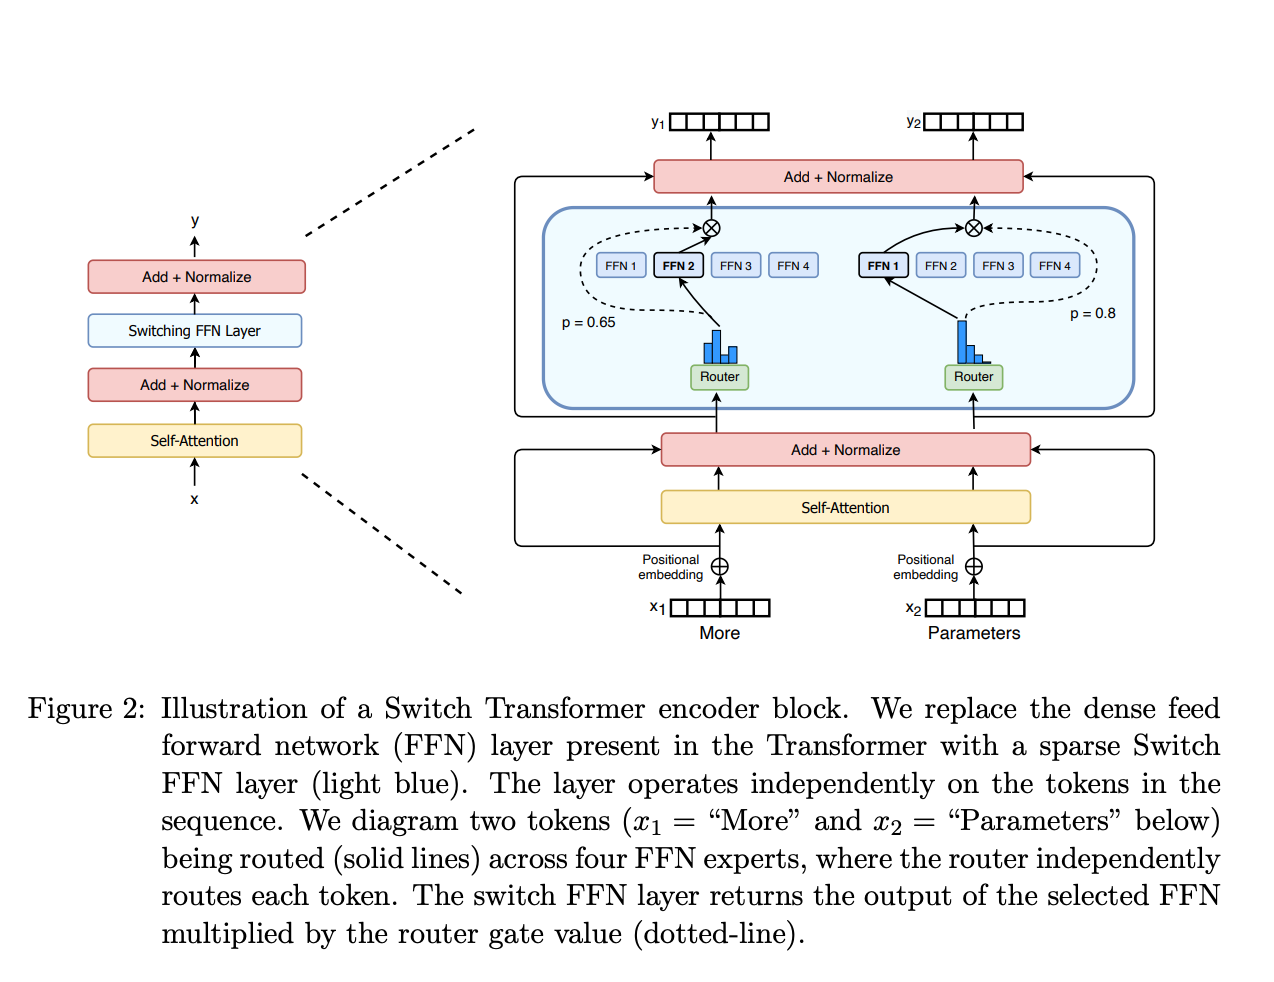

In [19]:
import torch
import torch.nn as nn
from transformers import BertModel, PreTrainedModel, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput

class BertWithMoEClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=10, num_experts=4, expert_hidden_size=256, pooling="mean", top_k=1):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.pooling = pooling
        self.top_k = top_k
        self.num_experts = num_experts
        hidden_size = self.bert.config.hidden_size

        # Gating network: input -> expert weights
        self.gate = nn.Linear(hidden_size, num_experts)

        # Experts: list of small MLPs
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, expert_hidden_size),
                nn.ReLU(),
                nn.Linear(expert_hidden_size, hidden_size)
            ) for _ in range(num_experts)
        ])

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def pool_hidden(self, hidden_states, attention_mask):
        if self.pooling == "cls":
            return hidden_states[:, 0]  # [CLS] token
        elif self.pooling == "mean":
            mask = attention_mask.unsqueeze(-1)
            summed = torch.sum(hidden_states * mask, dim=1)
            count = torch.clamp(mask.sum(dim=1), min=1e-9)
            return summed / count
        elif self.pooling == "max":
            mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
            hidden_states = hidden_states.masked_fill(mask == 0, -1e9)
            return torch.max(hidden_states, dim=1).values
        else:
            raise ValueError("Unsupported pooling type")

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.pool_hidden(outputs.last_hidden_state, attention_mask)  # (B, H)

        # Gating: choose experts
        gate_logits = self.gate(pooled_output)  # (B, num_experts)
        gate_weights = torch.softmax(gate_logits, dim=-1)  # soft selection
        topk_weights, topk_indices = torch.topk(gate_weights, self.top_k, dim=-1)  # (B, K)

        final_output = torch.zeros_like(pooled_output)
        for b in range(input_ids.size(0)):
            expert_sum = 0
            for i in range(self.top_k):
                expert_idx = topk_indices[b, i].item()
                expert = self.experts[expert_idx]
                # assert expert_idx < self.num_experts, f"Invalid expert index {expert_idx}, expected < {self.num_experts}"

                weight = topk_weights[b, i]
                expert_out = expert(pooled_output[b])  # (H)
                expert_sum += weight * expert_out
            final_output[b] = expert_sum

        final_output = self.dropout(final_output)
        logits = self.classifier(final_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [20]:
moe_model = BertWithMoEClassifier(
    model_name="bert-large-uncased",
    num_labels=len(label2id),
    num_experts=4,
    pooling="mean",
    top_k=2
)

In [21]:
# ===== IMPORTANT !!! =====
# Remember to resize your model to fit in your new vocab corpus
moe_model.bert.resize_token_embeddings(len(tokenizer))

Embedding(30525, 1024, padding_idx=0)

In [22]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="./moe-bert-graph-classifier",
    eval_strategy="epoch",        
    logging_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    metric_for_best_model="f1",
    save_total_limit=3,
    report_to=[],
    load_best_model_at_end=True,
    greater_is_better=True,
)

# Trainer
trainer = Trainer(
    model=moe_model,
    args=training_args,
    train_dataset=train_ds, # train_ds
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

/tmp/ipykernel_31866/1633361527.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.579400,1.599681,0.766548,0.740119
2,0.148600,1.259350,0.793348,0.765220
3,0.107200,1.737316,0.755247,0.721110
4,0.088700,1.824649,0.757184,0.720315
5,0.077900,1.801964,0.758153,0.724586


TrainOutput(global_step=4130, training_loss=0.2003716808254436, metrics={'train_runtime': 1515.9011, 'train_samples_per_second': 43.575, 'train_steps_per_second': 2.724, 'total_flos': 0.0, 'train_loss': 0.2003716808254436, 'epoch': 5.0})

## Discussion

We explored a Mixture-of-Experts (MoE) architecture built on top of a pre-trained BERT encoder for graph category classification. In our proposed model, a lightweight gating network selects from a set of expert MLPs, which transform the pooled representation before final classification. This MoE module introduces only a small increase in parameters (~4M, or <1.5% over BERT-large), yet consistently improves performance.

Specifically, while BERT-base and its MoE-augmented variant yield similar results—likely due to limited capacity of the base model—our experiments show that combining MoE with BERT-large significantly improves classification performance. The F1 score increases from 0.74 (BERT-large) to 0.765 (BERT-large + MoE), indicating that the MoE module is better able to leverage the increased representational power of larger backbone models.

These results suggest that while MoE may offer limited gains in small-model regimes, it becomes increasingly effective when paired with high-capacity encoders, where diverse sub-network specializations can be more fully utilized.
